In [1]:
from ipywidgets import interactive

import numpy as np
from scipy import signal as sg
from scipy.ndimage import filters, measurements as measure, morphology as morph

from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import load_img, show_img, show_hist, resize_img, save_img
from lib.edge_lib import threshold, get_points, overlay_points

img = load_img("bearing_scrached_fuji_tunnel.jpg") 

# Input image

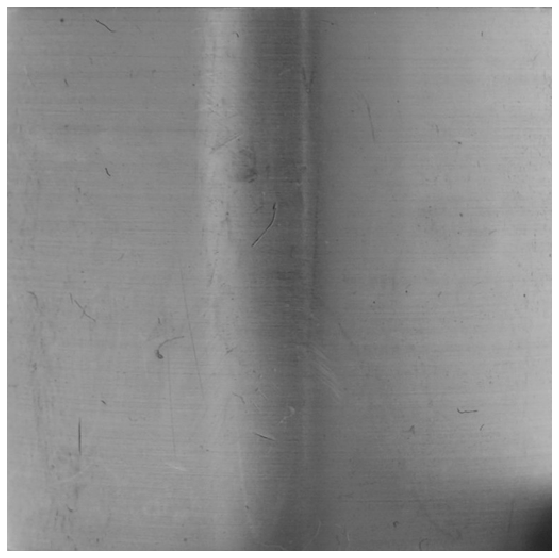

In [2]:
show_img(img, color="bw")

# Sobel edge detection

In [3]:
def sobel(img, sigma = 1):
    # Vertical Edges
    img_x = np.zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (0, 1), img_x)
    
    # Horizontal Edges
    img_y = np.zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (1, 0), img_y)
    
    # Magnitude
    magnitude = np.sqrt(img_x**2 + img_y**2)
    
    return magnitude

In [4]:
def detect_edges( sigma=0.4):
    response_img = sobel(img, sigma)
    show_img(response_img)
    
    return response_img

interactive_edgedetect = interactive(detect_edges, sigma=(0,2,0.1))
display(interactive_edgedetect)

interactive(children=(FloatSlider(value=0.4, description='sigma', max=2.0), Output()), _dom_classes=('widget-i…

### Threshold and binary

In [5]:
def threshold_and_binary(thresh=4):
    thresh_img = threshold(interactive_edgedetect.result, thresh)
    binary_img = thresh_img.astype(bool)
    show_img(thresh_img, binary_img)
    
    return binary_img

interactive_threshold = interactive(threshold_and_binary, thresh=(0,10,0.1))
display(interactive_threshold)

interactive(children=(FloatSlider(value=4.0, description='thresh', max=10.0), Output()), _dom_classes=('widget…

# Connect neighboring regions
using first a morphological dialation to connect the neighboring regions and then skeletonizing the regions again to end up with the precise markings.

In [51]:
def connect_neighboring_regions(connect=1, iters=2):
    struct = morph.generate_binary_structure(2,connect)
    dial_img = morph.binary_dilation(interactive_threshold.result, 
                                 structure=struct, iterations=iters)
    skeleton_img = skeletonize(dial_img)
    show_img(dial_img, skeleton_img, size=(17,17))
    
    return skeleton_img
    
interactive_connections = interactive(connect_neighboring_regions, connect=[1,2], iters=(1,5))
display(interactive_connections)

interactive(children=(Dropdown(description='connect', options=(1, 2), value=1), IntSlider(value=2, description…

## Keep only the big scraches
We start by lableing all connected regions and sorting them by area (try eccentricity?). We then only keep the ones that are bigger than a certain size.

In [53]:
def keep_only_big(area=17):
    struct = morph.generate_binary_structure(2,1)

    label_img = label(interactive_connections.result)
    scraches_img = remove_small_objects(label_img, area)
    
    dial_img = morph.binary_dilation(scraches_img, structure=struct,
                                 iterations=1)
    show_img(scraches_img.astype(bool), dial_img, size=(17,17))
    
    return scraches_img

interactive_area = interactive(keep_only_big, area=(1,50))
display(interactive_area)

interactive(children=(IntSlider(value=17, description='area', max=50, min=1), Output()), _dom_classes=('widget…

# Points on Image
Extract the points from the result image and overlay them on the input image.

In [ ]:
points = get_points(scraches_img, min_dist=10, allow_cluster=True)
overlay_points(img, points)